# Compare Stellar regression to SDSS spectra
To test the accuracy of the stellar regression method for determining zeropoint, lets compare that zeropoint to the those derived by an independent method of computing the magnitude from SDSS spectra of sources.

In [1]:
from tools import *
from thief.mangle_spectrum import mangle_spectrum2
%matplotlib notebook
import pandas as pd

from astroquery.sdss import SDSS
from astropy import coordinates as coords
import astropy.units as u

from copy import deepcopy
from scipy.signal import savgol_filter

from astropy.table import Table
from astropy.stats import sigma_clip

from chainconsumer import ChainConsumer

# stellar locus regression zeropoints
zpsr = np.load('output/zeropoint_kep.npy')
#zpsrc = np.load('output/crowding_zps_c16.npy')



plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig_width_pt = 240.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

In [119]:
coords.SkyCoord('05:33:22.0', '-70:40:37',unit=(u.hourangle, u.deg))

<SkyCoord (ICRS): (ra, dec) in deg
    (83.34166667, -70.67694444)>

In [2]:
from urllib.error import HTTPError

def SDSS_spec(coordinate):
    xid = SDSS.query_region(coordinate, spectro=True)
    if xid is not None:
        try:
            sp = SDSS.get_spectra(matches=xid)
            a = sp[0][1]
            spec = a.data
            wave = 10**spec['loglam']
            flux = spec['flux'] * 1e-17
            f = savgol_filter(flux,51,3)
            sdss_spec = S.ArraySpectrum(wave=10**spec['loglam'],
                                   flux=f,fluxunits='flam')
        except HTTPError:
            #print("spec doesn't actaully exist")
            sdss_spec = None
    else:
        sdss_spec = None

    return sdss_spec

def Syn_mag(pbs,spec):
    mag = {}
    for pb in pbs:
        if spec is not None:
            syn_mag = source_synphot.passband.synphot(spec,pbs[pb][0],zp=pbs[pb][1])
        else:
            syn_mag = np.nan
        mag[pb] = syn_mag
        
    return mag
    

In [2]:
passbands = at.Table.read('source_synphot/passbands/pbzptmag.txt',format='ascii')
pbnames = [x['obsmode'] for x in passbands if x['passband'].startswith("Kep")]
pbnames += [x['obsmode'] for x in passbands if x['passband'].startswith("PS1")]
pb_ps1 = [x['obsmode'] for x in passbands if x['passband'].startswith("PS1")][:3]
model_mags = 0.
magmodel = 'AB'
pbs = source_synphot.passband.load_pbs(pbnames, model_mags, magmodel)
pb_ps1 = source_synphot.passband.load_pbs(pb_ps1, model_mags, magmodel)
pbnames = pbs.keys()

data = pd.read_csv('K2_all_PS1_psc_ev_crowding_sdss2.csv')
#data = pd.read_csv('../calibration/kepler/crowding_test.csv')
data = data.iloc[(data['PDC'].values > 0)]
#cind =  ((data['campaign'].values == 16))# & (data['Channel'].values == 49))
#data = data.iloc[cind]
data['kMeanPSFMag'] = -2.5*np.log10(data['PDC'].values)
data['kMeanPSFMagErr'] = 0.1#(-2.5 / np.log(10)) * (data['PDCe'].values / data['PDC'].values) #0.05#np.abs(data['PDCe'].values) / np.abs(data['PDC'].values)/10
#data = data.iloc[abs(data['kMeanPSFMagErr'].values) < 0.1] 

data['gMeanPSFMag'] = data['g_combined']
data['gMeanPSFMagErr'] = data['ge_combined']
data['rMeanPSFMag'] = data['r_combined']
data['rMeanPSFMagErr'] = data['re_combined']
data['iMeanPSFMag'] = data['i_combined']
data['iMeanPSFMagErr'] = data['ie_combined']
data['zMeanPSFMag'] = data['z_combined']
data['zMeanPSFMagErr'] = data['ze_combined']

In [3]:
diff = abs(data['gMeanPSFMag'].values - data['cgMeanPSFMag'].values)
ind = diff < .1
data = data.iloc[ind]

ind = ((abs(data['zMeanPSFMagErr'].values) < 0.01) & 
       (abs(data['gMeanPSFMagErr'].values) < 0.01) & 
       (abs(data['rMeanPSFMagErr'].values) < 0.01) & 
       (abs(data['iMeanPSFMagErr'].values) < 0.01))
data = data.iloc[ind]

In [5]:
model = np.load('caspec_MS_mags.npy',allow_pickle=True).item()

In [6]:
def my_norm(Spec,pbs,mag):
    spec = deepcopy(Spec)
    m = Syn_mag(pbs,spec)
    m=m['ps1r']
    factor = 10**(-2/5*(mag-m))
    spec = S.ArraySpectrum(wave=spec.wave,waveunits=spec.waveunits,
                                   flux=spec.flux*factor,fluxunits=spec.fluxunits)
    return spec

In [ ]:
ind = []
fail = []
specs = []
for i in range(len(cord)):
    try:
        spec = SDSS_spec(cord[i])
        if spec is not None:
            print(i)
            spec.convert('flam')
            specs += [spec]
            ind += [i]
    except:
        fail += [i]

19320
19487
19541
19703
19748
19749
19786
19828
20006
20103
20104
20220
20349
20411
20445
20478
20530
20598
20744
20769
20773
20838
20871
20903
21042
21118
21246
21278
21324
21329
21370
21454
21477
21493
21549
21550
21611
21632
21707
21803
21836
21867
21907
21959
22046
22105
22145
22165
22182
22223
22339
22356
22482
22517
22531
22553
22579
22605
22608
22609
22618
22632
22666
22701
22714
22715
22809
22840
22845
22879
22917
22943
22951
23025
23074
23103
23128
23130
23143
23384
23393
23433
23434
23453
23495
23517
23519
23533
23540
23562
23593
23596
23649
23724
23747
23798
23801
23822
23830
23831
23856
23939
23994
23996
24012
24071
24112
24133
24134
24252
24274
24328
24330
24373
24395
24450
24455
24462
24487
24645
24662
24732
24744
24771
24819
24861
24862
24871
24872
24901
24970
25022
25023
25091
25137
25182
25183
25218
25278
25334
25382
25383
25407
25414
25437
25495
25496
25497
25542
25608
25641
25642
25672
25762
25765
25767
25800
25851
25857
25866
25880
25921
25940
25995
26006
26082
2613

In [ ]:
# get all available sdss spectra for Kepler sources
d = deepcopy(data)
cord = coords.SkyCoord(d.RAJ2000.values,d.DecJ2000.values, frame="icrs", unit="deg")
for pb in pbs:
    d[pb + '_synSDSS'] = np.nan
    d[pb + '_synSDSS_norm'] = np.nan

ind = []
fail = []
for i in range(len(cord)):
    try:
        spec = SDSS_spec(cord[i])
        spec2 = deepcopy(spec)
        if spec is not None:
            print(i)
            spec2.convert('flam')
            #spec = spec.renorm(d['gMeanPSFMag'].iloc[i],'abmag',pbs['ps1g'][0])
            mags = [d['gMeanPSFMag'].iloc[i],d['rMeanPSFMag'].iloc[i],d['iMeanPSFMag'].iloc[i]]
            flux = mangle_spectrum2(spec.wave,spec.flux,pb_ps1,mags)
            spec2 = S.ArraySpectrum(wave=spec.wave,flux=flux,fluxunits='flam')
            spec.convert('flam')
        mag = Syn_mag(pbs,spec)
        mag2 = Syn_mag(pbs,spec2)
        for pb in pbs:
            d[pb + '_synSDSS'].iloc[i] = mag[pb]
            d[pb + '_synSDSS_norm'].iloc[i] = mag2[pb]
    except:
        fail += [i]

19320
19487
19541
19703
19748
19749
19786
19828
20006
20103
20104
20220
20349
20411
20445
20478
20530
20598
20744
20769
20773
20838
20871
20903
21042
21118
21246
21278
21324
21329
21370
21454
21477
21493
21549
21550
21611
21632
21707
21803
21836
21867
21907
21959
no response


<IPython.core.display.Javascript object>

no response


<IPython.core.display.Javascript object>

no response


<IPython.core.display.Javascript object>

Warning! The following filters were not covered by the SED:
ps1g,ps1r,ps1i
22046
22105
22145
22165
22182
22223
22339
22356
22482
22517
22531
22553
22579
22605
22608
22609
22618
22632
22666
22701
22714
22715
22809
22840
22845
22879
22917
22943
22951
23025
23074
23103
23128
23130
23143
23384
23393
23433
23434
23453
23495
23517
23519
23533
23540
23562
23593
23596
23649
23724
23747
23798
23801
23822
23830
23831
23856
23939
23994
23996
24012
24071
24112
24133
24134
24252
24274
24328
24330
24373
24395
24450
24455
24462
24487
24645
24662
24732
24744
24771
24819
24861
24862
24871
24872
24901
24970
25022
25023
25091
25137
25182
25183
25218
25278
25334
25382
25383
25407
25414
25437
25495
25496
25497
25542
25608
25641
25642
25672
25762
25765
25767
25800
25851
25857
25866
25880
25921
25940
25995
26006
26082
26137
26161
26173
26306
26307
26393
26395
26470
26544
26601
26921
26923
26950
27078
27231
27313
27555
27556
27793
39785
39806
40020
40049
40072
40100
40279
40635
42894
44337
44417
44793
45070
4

<IPython.core.display.Javascript object>

no response


<IPython.core.display.Javascript object>

no response


<IPython.core.display.Javascript object>

Warning! The following filters were not covered by the SED:
ps1g,ps1r,ps1i
47563
47586
47597
47599
47630
47631
47637
47650
47670
47671
47693
47697
47723
47735
47766
47774
47788
47799
47809
47810
47811
47823
47846
Warning, 3 of 3843 bins contained negative fluxes; they have been set to zero.
47847
47893
47928
47935
47936
47952
47957
48003
48016
48055
48070
48077
48091
48097
48100
48102
48103
48104
48121
48132
48142
48146
48172
48176
48182
48190
48201
48210
48219
48220
48222
48236
48243
48265
48266
48270
48313
48314
48315
48328
48331
48337
48349
Warning, 2 of 3843 bins contained negative fluxes; they have been set to zero.
48353
48357
48365
48377
48403
48404
48405
48429
48437
Warning, 24 of 3806 bins contained negative fluxes; they have been set to zero.
48457
48460
48473
48474
48495
48500
48541
48558
48559
48562
48564
48575
48576
48578
48579
48614
48624
48637
48639
48669
48671
48694
48696
48701
48725
48745
48749
48766
48771
48772
48787
48789
48791
48792
48816
48817
48844
Warning, 4 of 3

<IPython.core.display.Javascript object>

no response


<IPython.core.display.Javascript object>

no response


<IPython.core.display.Javascript object>

Warning! The following filters were not covered by the SED:
ps1g,ps1r,ps1i
49209
49211
49228
49249
49254
49266
49270
49275
49276
49279
49308
49312
49313
49317
49333
49336
49337
49340
49360
49361
Warning, 5 of 3838 bins contained negative fluxes; they have been set to zero.
49362
49363
49368
49391
49392
49439
49440
49455
49480
49499
49504
49522
49528
49530
49539
49545
49570
49582
49588
no response


<IPython.core.display.Javascript object>

no response


<IPython.core.display.Javascript object>

no response


<IPython.core.display.Javascript object>

Warning! The following filters were not covered by the SED:
ps1g,ps1r,ps1i
49589
49590
49591
49594
49609
49610
49611
49635
49666
49667
49677
49679
49680
49691
49697
49703
49715
49716
49719
49758
49761
49762
49763
49766
49777
Warning, 2 of 3850 bins contained negative fluxes; they have been set to zero.
49779
49780
49798
49799
49800
49803
49805
49827
Warning, 2 of 3215 bins contained negative fluxes; they have been set to zero.
49828
49829
49830
49831
49846
49863
Warning, 12 of 3835 bins contained negative fluxes; they have been set to zero.
49864
49865
Warning, 3 of 3849 bins contained negative fluxes; they have been set to zero.
49884
49886
49887
49892
49939
49941
49946
49955
49956
49969
49970
49972
49974
Warning, 6 of 3847 bins contained negative fluxes; they have been set to zero.
49975
49994
49999
50000
50001
50016
50018
Warning, 4 of 3814 bins contained negative fluxes; they have been set to zero.
50019
50027
50037
50057
50070
50082
50089
50105
50120
50129
50131
50144
50146
50148


In [114]:
d.to_csv('K2_all_PS1_psc_ev_crowding_sdss2.csv',index=False)

{'Kep': nan, 'ps1g': nan, 'ps1r': nan, 'ps1i': nan, 'ps1z': nan, 'ps1y': nan}

In [109]:
d

,ID,campaign,Kpmag,RAJ2000,DecJ2000,objID,ps_score,raMean,decMean,raMeanErr,...,ps1g_synSDSS,ps1g_synSDSS_norm,ps1r_synSDSS,ps1r_synSDSS_norm,ps1i_synSDSS,ps1i_synSDSS_norm,ps1z_synSDSS,ps1z_synSDSS_norm,ps1y_synSDSS,ps1y_synSDSS_norm
1,240256177,11,15.209,264.202808,-29.983788,72012642029659459,0.835958,264.203038,-29.984112,0.00844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,235602262,11,14.614,258.183370,-29.922976,72092581833652554,0.944292,258.183390,-29.923136,0.01128,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,231475918,11,15.325,257.097258,-29.912254,72102570972375576,0.876125,257.097224,-29.912255,0.00389,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,240276746,11,15.316,265.249601,-29.914643,72102652496092704,0.980667,265.249599,-29.914656,0.00578,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,213305199,7,16.606,285.916016,-29.912827,72102859161154729,0.986667,285.916132,-29.913036,0.00679,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163353,202067461,0,14.800,100.590550,28.809440,142571005905561922,0.997500,100.590554,28.809457,0.00731,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163355,202066738,0,14.600,101.028900,28.868520,142641010288792817,0.995208,101.028904,28.868524,0.00457,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163356,202085664,0,15.900,101.397410,28.888150,142661013974826192,0.966280,101.397416,28.887992,0.00289,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163357,202067114,0,14.400,100.956330,28.919800,142701009562734305,0.983958,100.956319,28.919805,0.01055,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
d = deepcopy(data)
cut = deepcopy(data)
ind = ((d.gMeanPSFMag.values - d.rMeanPSFMag.values) > 0.2) & ((d.gMeanPSFMag.values - d.rMeanPSFMag.values) < 0.8)
cut = cut.iloc[ind]

ind = (cut.rMeanPSFMag.values <= 18) & (cut.rMeanPSFMag.values >= 14) & (np.isfinite(cut.ps1r_synSDSS.values)) 
cut = cut.iloc[ind]

channel_inds = cut['Channel'].values
slr = zpsr[16][channel_inds-1]


diff = -(cut.Kep_synSDSS_norm.values - cut.kMeanPSFMag.values - slr)


r = -(cut.ps1r_synSDSS_norm.values - cut.rMeanPSFMag.values)
g = -(cut.ps1g_synSDSS_norm.values - cut.gMeanPSFMag.values)
ib = -(cut.ps1i_synSDSS_norm.values - cut.iMeanPSFMag.values)
ind =  ((~sigma_clip(diff,sigma=3,masked=True).mask) &
        (~sigma_clip(g,sigma=3,masked=True).mask) & 
        (~sigma_clip(r,sigma=3,masked=True).mask)& 
        (~sigma_clip(ib,sigma=3,masked=True).mask))

In [11]:
len(cut)

116

<IPython.core.display.Javascript object>


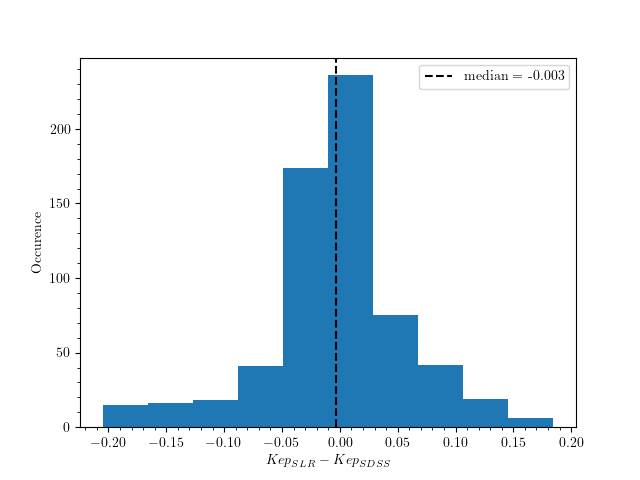

In [9]:
plt.figure()
plt.hist(diff[ind])
plt.ylabel('Occurence')
plt.xlabel('$Kep_{SLR}-Kep_{SDSS}$')
med = np.nanmedian(diff[ind])
plt.axvline(med,ls='--',color='k',
            label='median = '+ str(np.round(med,3)))
plt.minorticks_on()
#plt.xlim(24,27)
plt.legend()
#plt.savefig('c16_sdss_everest_kzp.pdf')

<IPython.core.display.Javascript object>


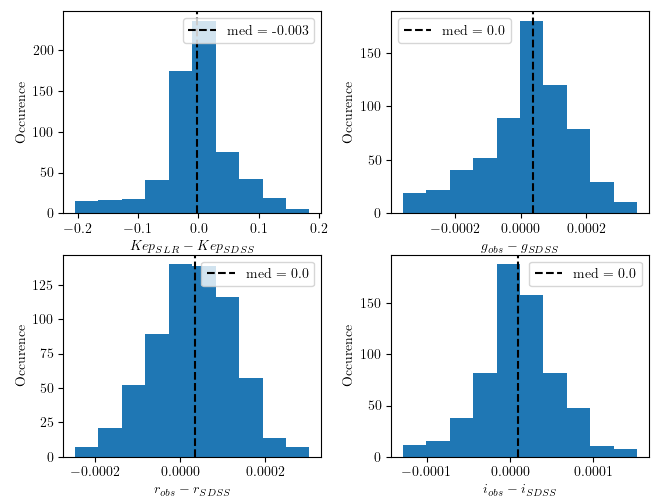

In [10]:
fig = plt.figure(figsize=(2*fig_width,2*fig_width))
plt.subplot(2,2,1)

plt.hist(diff[ind])
plt.ylabel('Occurence')
plt.xlabel('$Kep_{SLR}-Kep_{SDSS}$')
med = np.nanmedian(diff[ind])
plt.axvline(med,ls='--',color='k',
            label='med = '+ str(np.round(med,3)))
#plt.minorticks_on()
#plt.xlim(24,27)
plt.legend()

plt.subplot(2,2,2)
plt.hist(g[ind])
plt.xlabel('$g_{obs} - g_{SDSS}$')
plt.ylabel('Occurence')
#plt.minorticks_on()

med = np.nanmedian(g[ind])
plt.axvline(med,ls='--',color='k',
            label='med = '+ str(np.round(med,3)))
plt.legend()
#plt.xlim(-.5,.5)

plt.subplot(2,2,3)
plt.hist(r[ind])
plt.xlabel('$r_{obs} - r_{SDSS}$')
plt.ylabel('Occurence')
#plt.minorticks_on()
med = np.nanmedian(r[ind])
plt.axvline(med,ls='--',color='k',
            label='med = '+ str(np.round(med,3)))
plt.legend()
#plt.xlim(-.5,.5)

plt.subplot(2,2,4)
plt.hist(ib[ind])
plt.xlabel('$i_{obs} - i_{SDSS}$')
plt.ylabel('Occurence')
#plt.minorticks_on()
med = np.nanmedian(ib[ind])
plt.axvline(med,ls='--',color='k',
            label='med = '+ str(np.round(med,3)))

plt.legend()

plt.tight_layout()
fig.set_size_inches(fig_width*2,fig_width*1.5)
#plt.savefig('c16_sdss_everest_error2.pdf')

In [12]:
channel_inds = data['Channel'].values
slr = zpsr2[channel_inds-1]


diff = -(d.Kep_synSDSS.values - d.kMeanPSFMag.values - slr)

IndexError: index 52 is out of bounds for axis 0 with size 20

In [ ]:
cut.rMeanPSFMag.values
plt.figure()
plt.plot(d.gMeanPSFMag.values-d.rMeanPSFMag.values,-(d.ps1i_synSDSS.values - d.iMeanPSFMag.values),'.')

# See how each interacts

In [41]:
gc = 10**(-2/5 *(cut['gMeanPSFMag'].values-25))
rc = 10**(-2/5 *(cut['rMeanPSFMag'].values-25))
ic = 10**(-2/5 *(cut['iMeanPSFMag'].values-25))
zc = 10**(-2/5 *(cut['zMeanPSFMag'].values-25))

k = data['kMeanPSFMag'].values

kcom = 0.37528924*gc + 0.37592223*rc + 0.19063787*ic + 0.0586959*zc - 0.08385487*(gc-rc)
kcom = -2.5*np.log10(kcom) + 25

In [14]:
def PS1_to_Kepler_mags(g,r,i,z):
    """
    Input the PS1 magnitudes for the g, r, i, and z filters to get the estimated Kepler magnitude.
    """
    gc = 10**(-2/5 *(g-25))
    rc = 10**(-2/5 *(r-25))
    ic = 10**(-2/5 *(i-25))
    zc = 10**(-2/5 *(z-25))

    kcom = 0.37528924*gc + 0.37592223*rc + 0.19063787*ic + 0.0586959*zc - 0.08385487*(gc-rc)
    kcom = -2.5*np.log10(kcom) + 25
    return kcom

In [65]:
kslr = cut.kMeanPSFMag.values + slr
sdss_kslr = (cut.Kep_synSDSS_norm.values-kslr) * 1e3
sdss_kcom = (cut.Kep_synSDSS_norm.values-kcom) * 1e3
sdss_epic = (cut.Kep_synSDSS_norm.values-cut['Kpmag'].values) * 1e3
sigmask = (~sigma_clip(sdss_kslr).mask & ~sigma_clip(sdss_kcom).mask & ~sigma_clip(sdss_epic).mask)

In [70]:
True * False

0

In [71]:
arr = np.array([sdss_kslr[ind*sigmask],sdss_kcom[ind*sigmask],sdss_epic[ind*sigmask]])

<IPython.core.display.Javascript object>


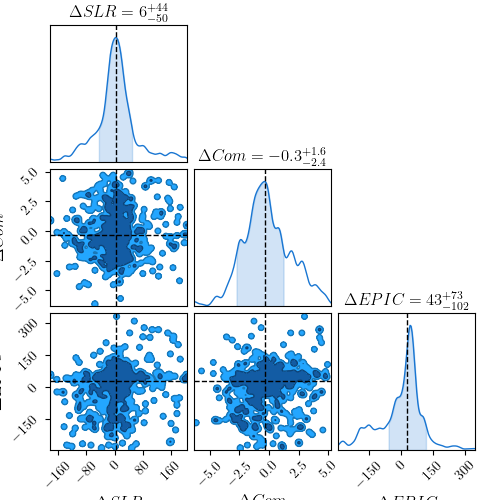

In [79]:
from chainconsumer import ChainConsumer

mean = [np.nanmedian(arr[0]),np.nanmedian(arr[1]),np.nanmedian(arr[2])]

c = ChainConsumer()
c.add_chain(arr.T, parameters=["$\Delta SLR$", "$\Delta Com$", "$\Delta EPIC$"])
c.configure(flip=False)
c.plotter.plot(figsize="column", truth=mean)
plt.savefig('kep_sdss_diff.pdf',bbox_inches='tight')

<IPython.core.display.Javascript object>


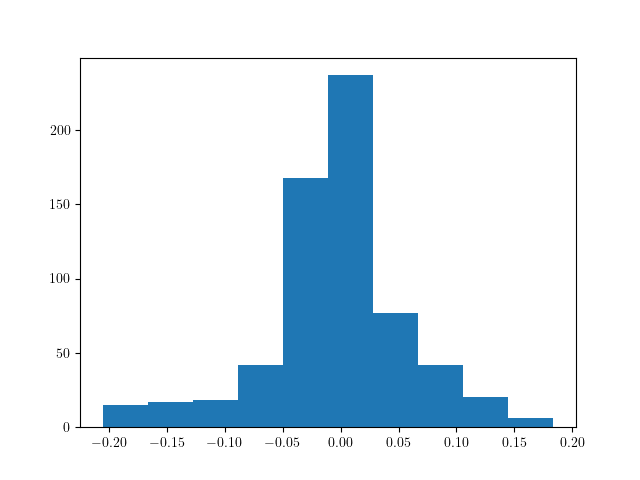

(array([ 15.,  17.,  18.,  42., 168., 237.,  77.,  42.,  20.,   6.]),
 array([-0.205977  , -0.16698559, -0.12799418, -0.08900278, -0.05001137,
        -0.01101996,  0.02797145,  0.06696286,  0.10595427,  0.14494567,
         0.18393708]),
 <BarContainer object of 10 artists>)

In [19]:
test = kslr - kcom

plt.figure()
plt.hist(test[ind])

In [53]:
a = cut.Kpmag.values - kslr

In [56]:
a.shape

(116,)

<IPython.core.display.Javascript object>


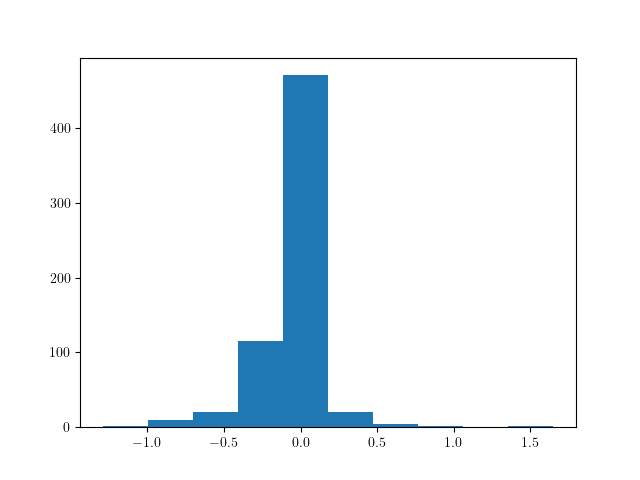

(array([  1.,   9.,  20., 115., 471.,  20.,   4.,   1.,   0.,   1.]),
 array([-1.29298516, -0.99861721, -0.70424926, -0.40988131, -0.11551337,
         0.17885458,  0.47322253,  0.76759047,  1.06195842,  1.35632637,
         1.65069431]),
 <BarContainer object of 10 artists>)

In [20]:
plt.figure()
plt.hist(-(cut.Kpmag.values - kslr)[ind])

<IPython.core.display.Javascript object>


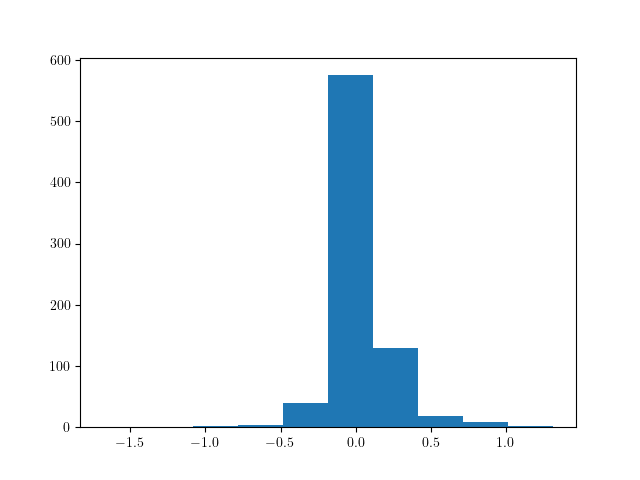

(array([  1.,   0.,   2.,   4.,  40., 575., 130.,  18.,   8.,   2.]),
 array([-1.68474433, -1.3845487 , -1.08435307, -0.78415743, -0.4839618 ,
        -0.18376617,  0.11642946,  0.4166251 ,  0.71682073,  1.01701636,
         1.31721199]),
 <BarContainer object of 10 artists>)

In [21]:
plt.figure()
plt.hist(cut.Kpmag.values - kcom)

# look at full c16 sample

In [22]:
gc = 10**(-2/5 *(d['gMeanPSFMag'].values-25))
rc = 10**(-2/5 *(d['rMeanPSFMag'].values-25))
ic = 10**(-2/5 *(d['iMeanPSFMag'].values-25))
zc = 10**(-2/5 *(d['zMeanPSFMag'].values-25))

kcom = 0.37528924*gc + 0.37592223*rc + 0.19063787*ic + 0.0586959*zc - 0.08385487*(gc-rc)
kcom = -2.5*np.log10(kcom) + 25

In [23]:
channel_inds = d['Channel'].values
slr = zpsr[16][channel_inds-1]
kslr = d.kMeanPSFMag.values + slr

epic = d['Kpmag'].values

In [24]:
ind = (((d.gMeanPSFMag.values - d.rMeanPSFMag.values) > 0.2) & ((d.gMeanPSFMag.values - d.rMeanPSFMag.values) < 0.8) &
      (d.rMeanPSFMag.values <= 16.5) & (d.rMeanPSFMag.values >= 14))
dd = d.iloc[ind]

epic_diff = (kslr-epic)[ind]
com_diff = (kcom-epic)[ind]

ind = (~sigma_clip(epic_diff).mask & ~sigma_clip(com_diff).mask)
dd = dd.iloc[ind]

In [25]:
arr = np.array([epic_diff[ind],com_diff[ind]])

<IPython.core.display.Javascript object>


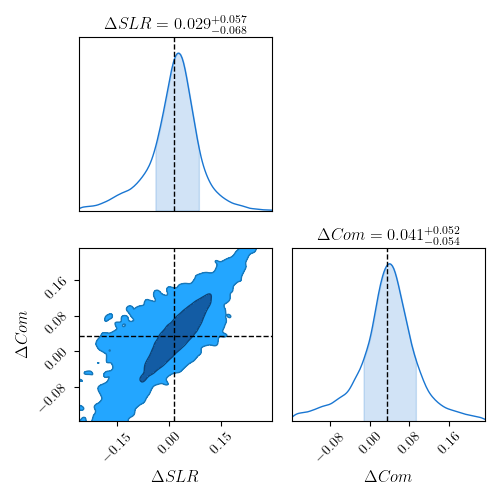

In [26]:


mean = [np.nanmean(arr[0]),np.nanmean(arr[1])]

c = ChainConsumer()
c.add_chain(arr.T, parameters=["$ \Delta SLR$", "$\Delta Com$"])
c.configure(flip=False)
fig = c.plotter.plot(figsize="column", truth=mean)
p = fig.axes[3]
text = p.get_title()
#p.set_ylabel(text,fontsize=14,rotation=270, labelpad=20)
#p.yaxis.set_label_position("right")
#p.set_title('')
plt.tight_layout()
plt.savefig('epic_comparison.pdf')

<IPython.core.display.Javascript object>


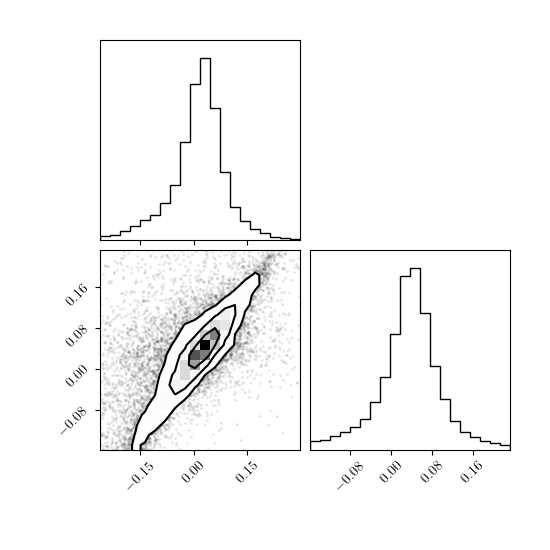

In [27]:
import corner
figure = corner.corner(arr.T)

In [231]:
magind = np.argsort(dd.rMeanPSFMag.values)
test = arr[0]-np.nanmedian(arr[0])
test = test[magind]
sav = savgol_filter(test[magind],501,3,)

bins = [[14,14.5],[14.5,15],[15,15.5],[15.5,16],[16,16.5]]
mags = dd.rMeanPSFMag.iloc[magind].values
av = []
for b in bins:
    eh = (mags >= b[0]) & (mags < b[1])
    av += [np.nanmedian(test[eh])]

<IPython.core.display.Javascript object>


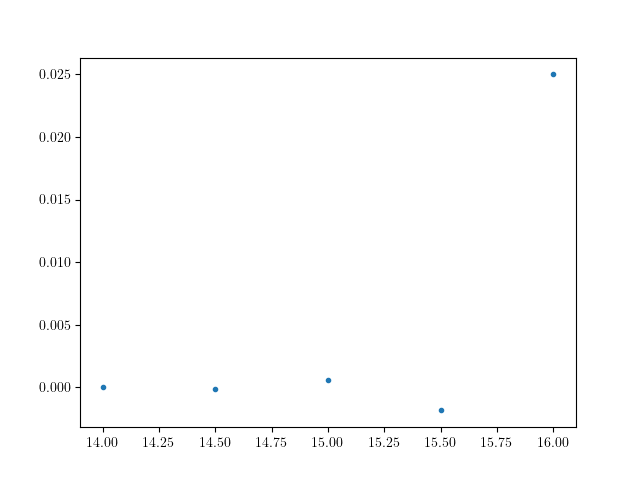

In [233]:
plt.figure()
plt.plot([14,14.5,15,15.5,16],av,'.')

<IPython.core.display.Javascript object>


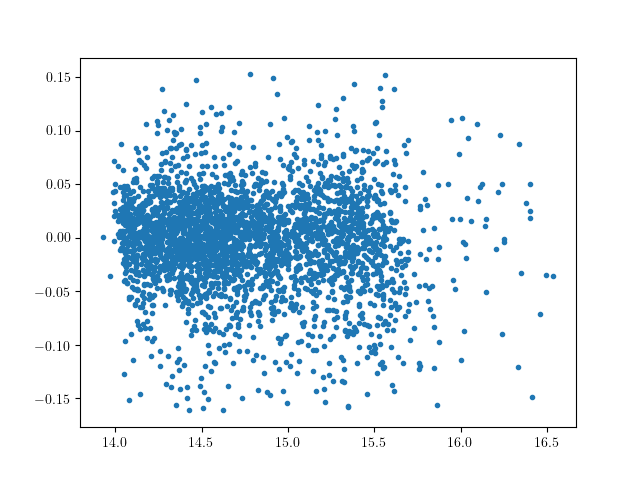

In [234]:
plt.figure()
plt.plot(dd.Kpmag.iloc[magind],test,'.') 

<IPython.core.display.Javascript object>


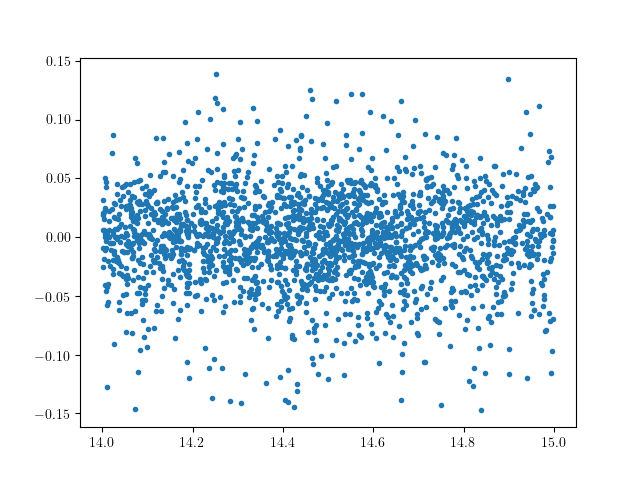

In [224]:
plt.figure()
plt.plot(dd.rMeanPSFMag.iloc[magind],test,'.') 
#plt.plot(dd.rMeanPSFMag,arr[1]-np.nanmedian(arr[1]),'.')

In [239]:
slr.shape

(8595, 84)

In [243]:
slr

array([25.29121733, 25.29121733, 25.29121733, ..., 25.25311708,
       25.27131821, 25.27131821])

In [81]:
d = deepcopy(data)
d = d.iloc[data['campaign'].values == 6]
gc = 10**(-2/5 *(d['gMeanPSFMag'].values-25))
rc = 10**(-2/5 *(d['rMeanPSFMag'].values-25))
ic = 10**(-2/5 *(d['iMeanPSFMag'].values-25))
zc = 10**(-2/5 *(d['zMeanPSFMag'].values-25))

kcom = 0.37528924*gc + 0.37592223*rc + 0.19063787*ic + 0.0586959*zc - 0.08385487*(gc-rc)
kcom = (0.25925186*gc + 0.4979566*rc + 0.17658766*ic + 0.06823672*zc)*(gc/rc)**(0.03316101)
kcom = -2.5*np.log10(kcom) + 25

channel_inds = d['Channel'].values
camp_inds = d['campaign'].values
slr = zpsr[camp_inds-1,channel_inds-1]
slr[slr == 0] = np.nan
kslr = d.kMeanPSFMag.values + slr

epic = d['Kpmag'].values

ind = (((d.gMeanPSFMag.values - d.rMeanPSFMag.values) > 0.2) & 
       ((d.gMeanPSFMag.values - d.rMeanPSFMag.values) < 0.8) &
      (d.rMeanPSFMag.values <= 18) & (d.rMeanPSFMag.values >= 14))
dd = d.iloc[ind]

epic_diff = (kslr-epic)[ind]
com_diff = (kcom-epic)[ind]
e = epic[ind]
ind = (~sigma_clip(epic_diff).mask & ~sigma_clip(com_diff).mask & np.isfinite(epic_diff))
dd = dd.iloc[ind]
arr = np.array([epic_diff[ind],com_diff[ind]])


In [28]:
extinctions = np.load('output/extinctions.npy')

<IPython.core.display.Javascript object>


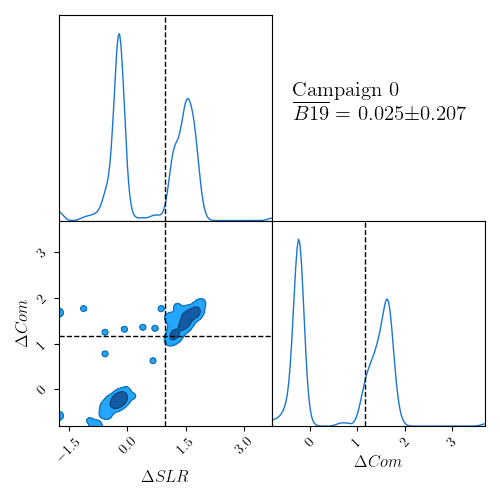

<IPython.core.display.Javascript object>


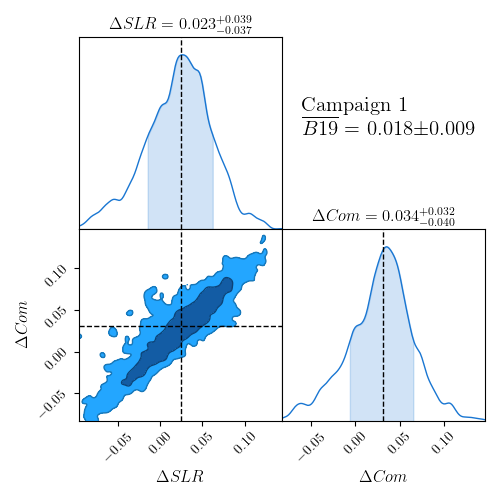

<IPython.core.display.Javascript object>


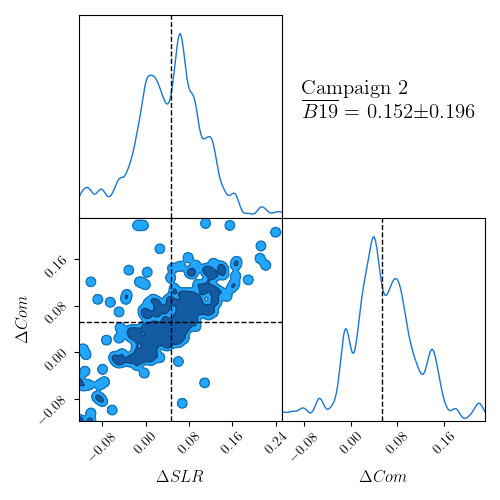

<IPython.core.display.Javascript object>


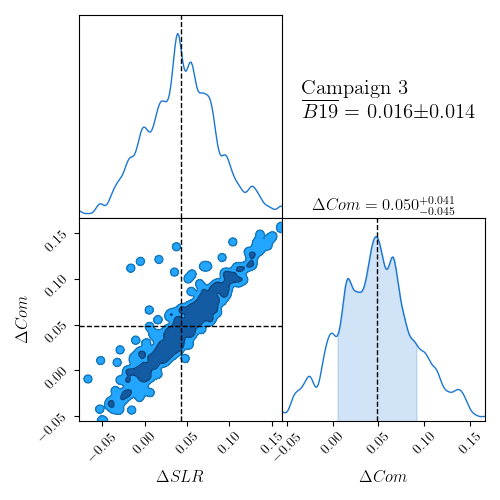

<IPython.core.display.Javascript object>


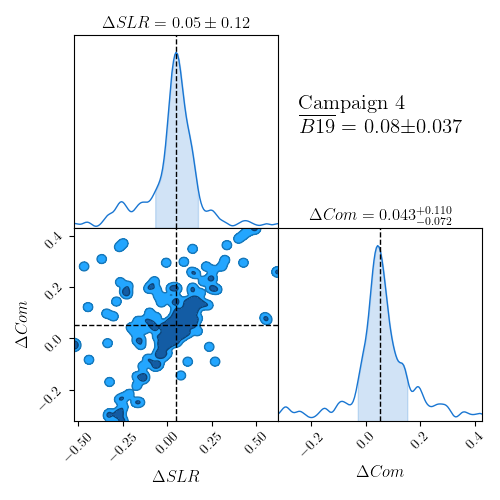

<IPython.core.display.Javascript object>


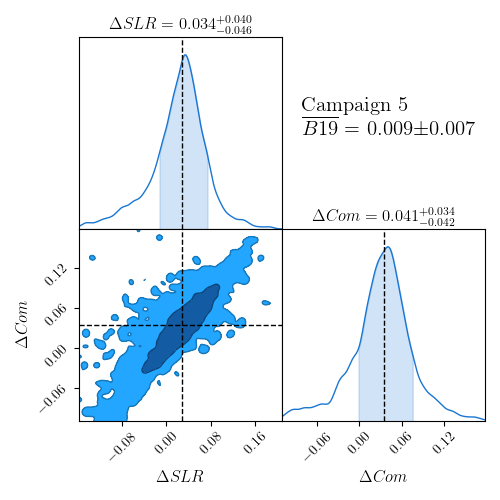

<IPython.core.display.Javascript object>


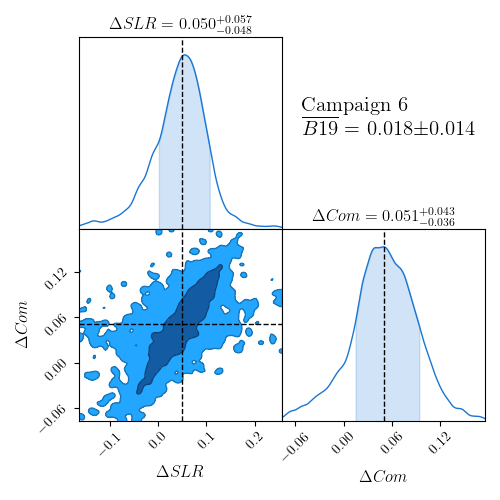

<IPython.core.display.Javascript object>


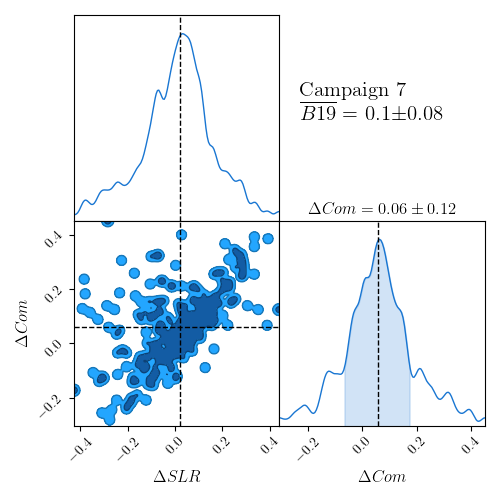

<IPython.core.display.Javascript object>


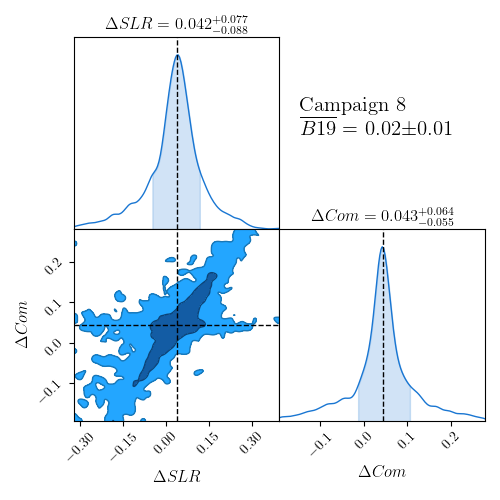

<IPython.core.display.Javascript object>


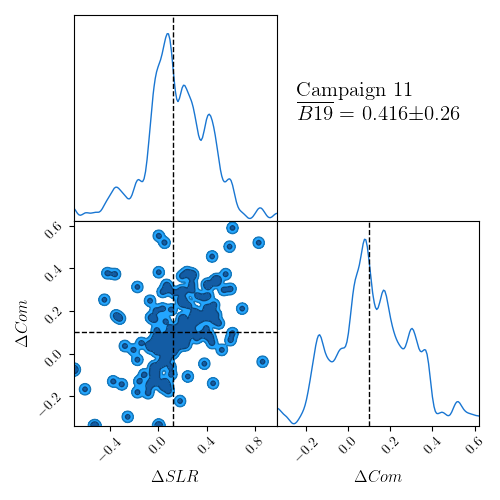

<IPython.core.display.Javascript object>


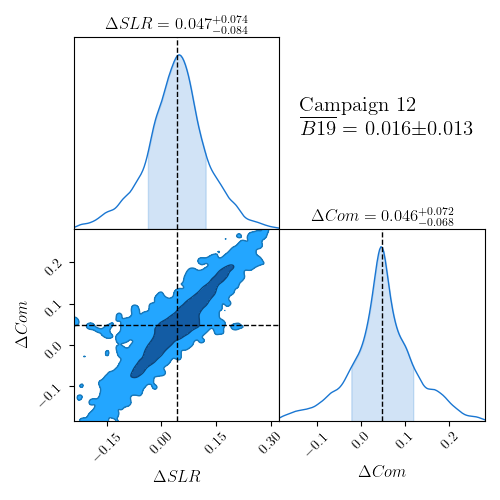

<IPython.core.display.Javascript object>


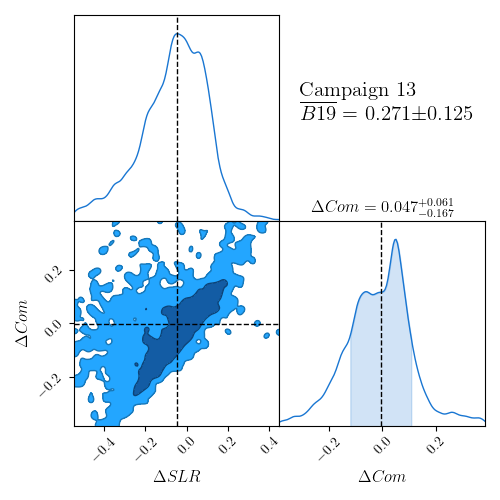

<IPython.core.display.Javascript object>


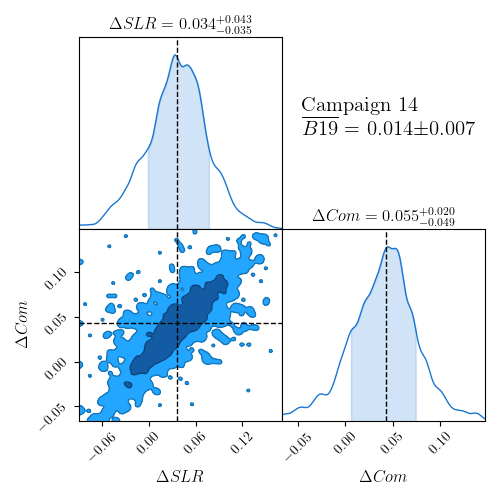

<IPython.core.display.Javascript object>


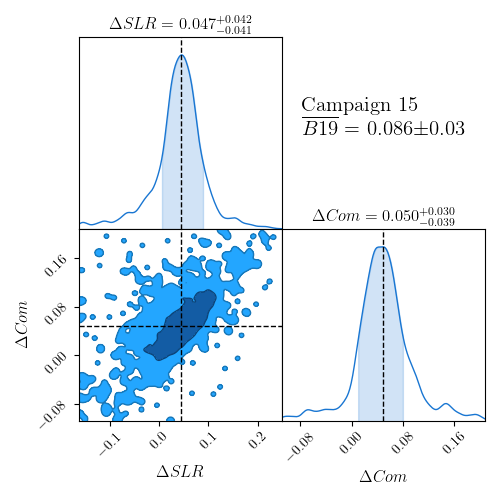

<IPython.core.display.Javascript object>


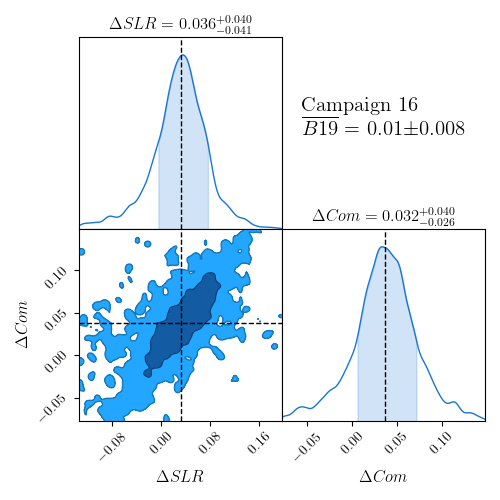

<IPython.core.display.Javascript object>


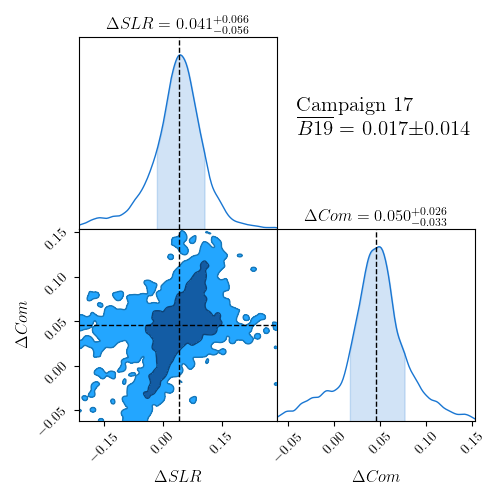

<IPython.core.display.Javascript object>


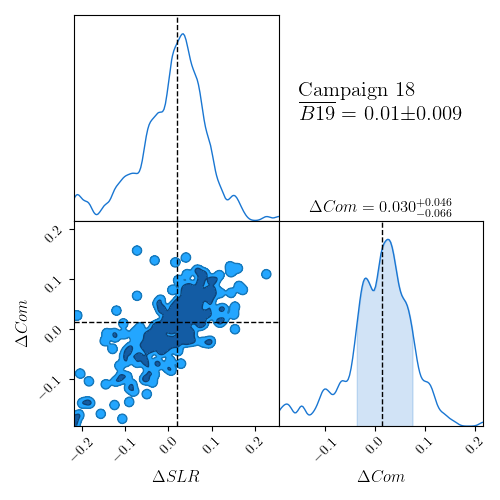

In [35]:
dslr = np.zeros(19)
dcom = np.zeros(19)

for o in range(19):
    #o += 1
    #if o == 9:
    #    sdfas
    d = deepcopy(data)
    d = d.iloc[data['campaign'].values == o]
    ind = abs(d.crMeanPSFMag.values - d.rMeanPSFMag.values) < .1
    d = d.iloc[ind]
    ind = abs(d.gMeanPSFMag.values - d.rMeanPSFMag.values) < .9
    d = d.iloc[ind]
    gc = 10**(-2/5 *(d['gMeanPSFMag'].values-25))
    rc = 10**(-2/5 *(d['rMeanPSFMag'].values-25))
    ic = 10**(-2/5 *(d['iMeanPSFMag'].values-25))
    zc = 10**(-2/5 *(d['zMeanPSFMag'].values-25))

    kcom = 0.37528924*gc + 0.37592223*rc + 0.19063787*ic + 0.0586959*zc - 0.08385487*(gc-rc)
    kcom = (0.25925186*gc + 0.4979566*rc + 0.17658766*ic + 0.06823672*zc)*(gc/rc)**(0.03316101)
    kcom = -2.5*np.log10(kcom) + 25

    channel_inds = d['Channel'].values
    camp_inds = d['campaign'].values
    zz = zpsr[o]
    ee = extinctions[o]
    e = []
    z = []
    for i in range(len(channel_inds)):
        z += [zz[channel_inds[i]-1]]
        e += [ee[channel_inds[i]-1]]
    slr = np.array(z)#zpsr[camp_inds-1,channel_inds-1]
    slr[slr == 0] = np.nan
    exs = np.array(e)
    exs[slr == 0] = np.nan
    std = np.nanstd(exs)
    exs = np.nanmedian(exs)
    
    kslr = d.kMeanPSFMag.values + slr

    epic = d['Kpmag'].values

    ind = (((d.gMeanPSFMag.values - d.rMeanPSFMag.values) > 0.2) & 
           ((d.gMeanPSFMag.values - d.rMeanPSFMag.values) < 0.8) &
          (d.rMeanPSFMag.values <= 18) & (d.rMeanPSFMag.values >= 14))
    dd = d.iloc[ind]

    epic_diff = (kslr-epic)[ind]
    com_diff = (kcom-epic)[ind]
    e = epic[ind]
    if len(epic_diff) > 0:
        ind = (~sigma_clip(epic_diff).mask & ~sigma_clip(com_diff).mask & np.isfinite(epic_diff))
        dd = dd.iloc[ind]
        arr = np.array([epic_diff[ind],com_diff[ind]])
        if len(arr.T) > 0:
            #dslr[o,0] = np.percentile(epic_diff[ind],16)
            #dslr[o,1] = np.percentile(epic_diff[ind],50)
            #dslr[o,2] = np.percentile(epic_diff[ind],84)
            
            #dcom[o,0] = np.percentile(com_diff[ind],16)
            #dcom[o,1] = np.percentile(com_diff[ind],50)
            #dcom[o,2] = np.percentile(com_diff[ind],84)
            
            mean = [np.nanmedian(arr[0]),np.nanmedian(arr[1])]

            c = ChainConsumer()
            c.add_chain(arr.T, parameters=["$ \Delta SLR$", "$\Delta Com$"])
            c.configure(flip=False)
            fig = c.plotter.plot(figsize="column", truth=mean)
            p = fig.axes[3]
            text = p.get_title()
            dslr[o] = c.analysis.get_summary()['$ \\Delta SLR$'][1]
            dcom[o] = c.analysis.get_summary()['$\\Delta Com$'][1]
            plt.tight_layout()
            plt.subplots_adjust(wspace=0,hspace=0)
            text = 'Campaign {}\n'.format(o) + r'$\overline{B19}=$ ' + str(np.round(exs,3))+'$\pm$'+str(np.round(std,3))
            plt.text(0.1,1.5,text, transform=plt.gca().transAxes,fontsize=15)
            plt.savefig('figs/comparison/epic_comparison{}.pdf'.format(o))

In [ ]:
c.analysis.get_summary()['$ \\Delta SLR$'][1]

In [62]:
c.analysis.get_summary()['$\\Delta Com$'][1]

0.024830329529881567

In [69]:
dcom

array([-0.23143328,  0.036956  ,  0.03981261,  0.04956532,  0.04570926,
        0.04098602,  0.05170891,  0.07831792,  0.04380326,  0.        ,
        0.        ,  0.17390537,  0.04552354,  0.04862788,  0.04696198,
        0.04137287,  0.03187673,  0.05007233,  0.02483033])

In [75]:
ddcom = deepcopy(dcom)
ddcom[ddcom==0] = np.nan
ddcom = ddcom[np.isfinite(ddcom)]
maskcom = ~sigma_clip(ddcom).mask

In [76]:
ddslr = deepcopy(dslr)
ddslr[ddslr==0] = np.nan
ddslr = ddslr[np.isfinite(ddslr)]
maskslr = ~sigma_clip(ddslr).mask

In [66]:
mask = ~sigma_clip(ddcom).mask

<IPython.core.display.Javascript object>


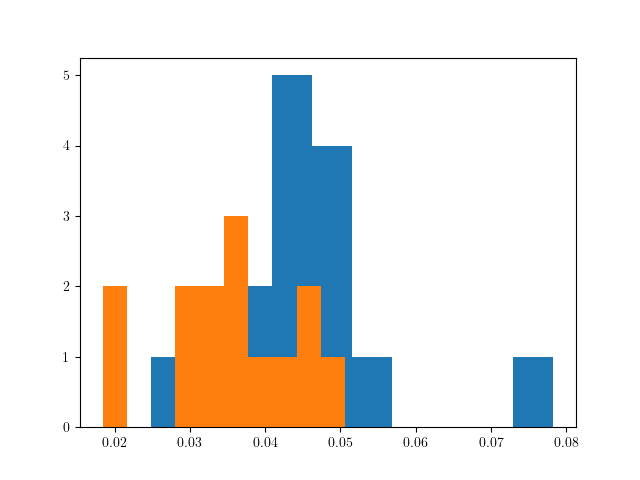

(array([2., 0., 0., 2., 2., 3., 1., 1., 2., 1.]),
 array([0.01841008, 0.02163564, 0.02486121, 0.02808677, 0.03131234,
        0.0345379 , 0.03776347, 0.04098904, 0.0442146 , 0.04744017,
        0.05066573]),
 <a list of 10 Patch objects>)

In [77]:
plt.figure()
plt.hist(ddcom[maskcom])
plt.hist(ddslr[maskslr])

In [78]:
c = ddcom[maskcom]
s = ddslr[maskslr]

In [88]:
med = np.percentile(c,50)*1e3
low = np.percentile(c,16)*1e3
high = np.percentile(c,84)*1e3

In [89]:
print(med,low-med, high-med)

45.52353708175466 -7.881950628521203 4.427112379524075


In [90]:
med = np.percentile(s,50)*1e3
low = np.percentile(s,16)*1e3
high = np.percentile(s,84)*1e3
print(med,low-med, high-med)

34.76630728089003 -4.4401786108822705 9.335193131179004


<IPython.core.display.Javascript object>


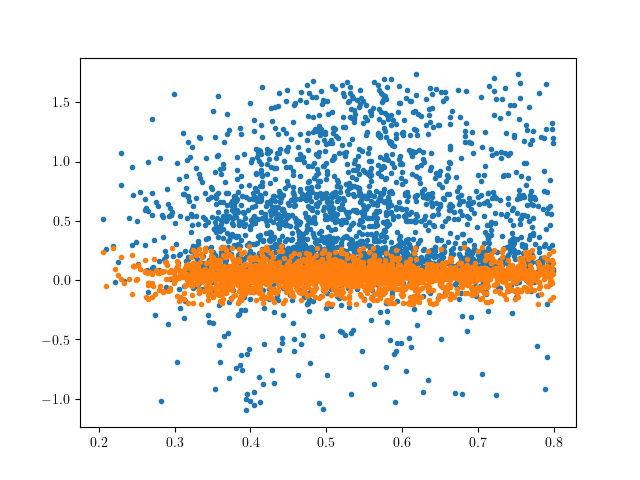

In [100]:
plt.figure()
plt.plot(dd.gMeanPSFMag-dd.rMeanPSFMag,epic_diff[ind],'.')
plt.plot(dd.gMeanPSFMag-dd.rMeanPSFMag,com_diff[ind],'.')

<IPython.core.display.Javascript object>


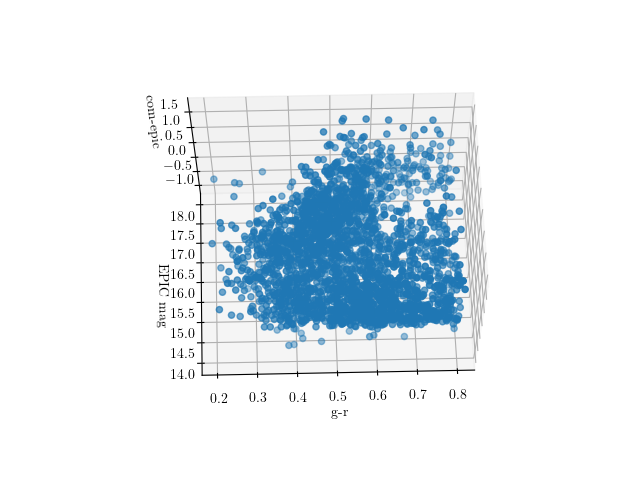

Text(0.5, 0, 'com-epic')

In [99]:
fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.scatter3D(dd.gMeanPSFMag-dd.rMeanPSFMag,dd.rMeanPSFMag,com_diff[ind])
ax.scatter3D(dd.gMeanPSFMag-dd.rMeanPSFMag,dd.rMeanPSFMag,epic_diff[ind])
ax.set_ylabel('EPIC mag')
ax.set_xlabel('g-r')
ax.set_zlabel('com-epic')

In [54]:
len(epic)

4193

In [103]:
dd.rMeanKronMag.values

71528     16.641899
71529     15.955300
71728     14.619400
71770     17.017200
72403     16.580000
            ...    
121287    16.072100
121331    17.038000
121561    15.626400
121736    14.052900
121812    14.955700
Name: rMeanKronMag, Length: 2569, dtype: float64

<IPython.core.display.Javascript object>


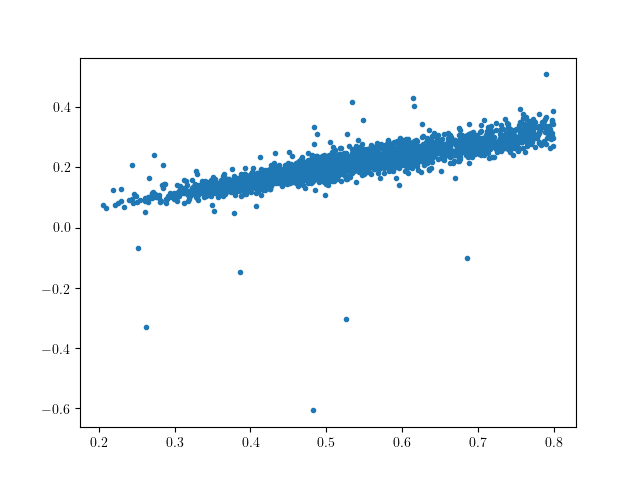

In [117]:
plt.figure()
plt.plot(dd.gMeanPSFMag-dd.rMeanPSFMag,dd.rMeanPSFMag-dd.iMeanPSFMag,'.')


<IPython.core.display.Javascript object>


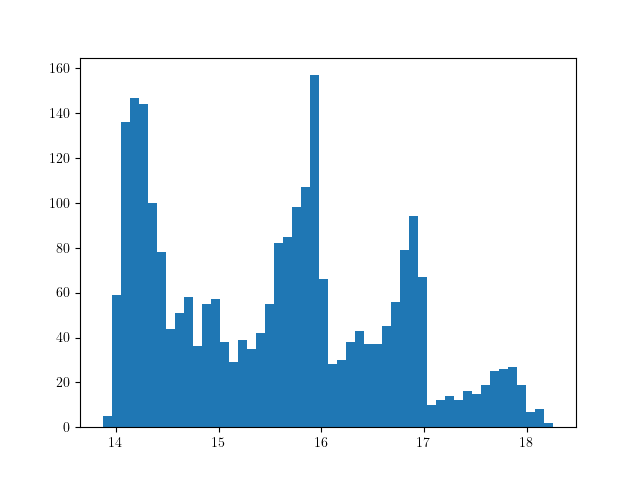

(array([  5.,  59., 136., 147., 144., 100.,  78.,  44.,  51.,  58.,  36.,
         55.,  57.,  38.,  29.,  39.,  35.,  42.,  55.,  82.,  85.,  98.,
        107., 157.,  66.,  28.,  30.,  38.,  43.,  37.,  37.,  45.,  56.,
         79.,  94.,  67.,  10.,  12.,  14.,  12.,  16.,  15.,  19.,  25.,
         26.,  27.,  19.,   7.,   8.,   2.]),
 array([13.87   , 13.95774, 14.04548, 14.13322, 14.22096, 14.3087 ,
        14.39644, 14.48418, 14.57192, 14.65966, 14.7474 , 14.83514,
        14.92288, 15.01062, 15.09836, 15.1861 , 15.27384, 15.36158,
        15.44932, 15.53706, 15.6248 , 15.71254, 15.80028, 15.88802,
        15.97576, 16.0635 , 16.15124, 16.23898, 16.32672, 16.41446,
        16.5022 , 16.58994, 16.67768, 16.76542, 16.85316, 16.9409 ,
        17.02864, 17.11638, 17.20412, 17.29186, 17.3796 , 17.46734,
        17.55508, 17.64282, 17.73056, 17.8183 , 17.90604, 17.99378,
        18.08152, 18.16926, 18.257  ]),
 <a list of 50 Patch objects>)

In [110]:
plt.figure()
plt.hist(dd.Kpmag,bins=50)